In [1]:
%cd ../

/mnt/kireev/pycharm-deploy/vtb


In [2]:
import pickle
import random

In [3]:
from glob import glob

In [4]:
import numpy as np
import pandas as pd

In [5]:
import torch
import pytorch_lightning as pl

In [6]:
from pyhocon import ConfigFactory

In [7]:
import matplotlib.pyplot as plt

In [8]:
from dltranz.data_load.iterable_processing.category_size_clip import CategorySizeClip
from dltranz.data_load import augmentation_chain
from dltranz.data_load.augmentations.seq_len_limit import SeqLenLimit
from dltranz.data_load.augmentations.random_slice import RandomSlice

from dltranz.seq_encoder import create_encoder

from dltranz.metric_learn.sampling_strategies import get_sampling_strategy
from dltranz.metric_learn.losses import get_loss

from dltranz.tb_interface import get_scalars

In [9]:
from vtb_code.data import PairedDataset, paired_collate_fn, DropDuplicate
from vtb_code.metrics import PrecisionK, MeanReciprocalRankK, ValidationCallback

In [10]:
FOLD_ID = 1

In [11]:
fold_id_test = FOLD_ID

In [12]:
folds_count = len(glob('data/train_matching_*.csv'))
folds_count

6

In [13]:
# fold_id_valid = np.random.choice([i for i in range(folds_count) if i != fold_id_test], size=1)[0]
fold_id_valid = (fold_id_test + 1) % folds_count
fold_id_valid

2

In [14]:
df_matching_train = pd.concat([pd.read_csv(f'data/train_matching_{i}.csv')
                              for i in range(folds_count) 
                              if i not in (fold_id_test, fold_id_valid)])
df_matching_valid = pd.read_csv(f'data/train_matching_{fold_id_valid}.csv')
df_matching_test = pd.read_csv(f'data/train_matching_{fold_id_test}.csv')

In [15]:
[len(df) for df in [df_matching_train, df_matching_valid, df_matching_test]]

[11721, 2930, 2930]

In [16]:
%%time
with open('data/features.pickle', 'rb') as f:
    (
        features_trx_train,
        features_trx_valid,
        features_trx_test,
        features_click_train,
        features_click_valid,
        features_click_test,
    ) = pickle.load(f)

CPU times: user 9.85 s, sys: 4.34 s, total: 14.2 s
Wall time: 14.2 s


In [17]:
class ResNetBlock(torch.nn.Module):
    def __init__(self, size, internal_size=1024, dropout=0.1):
        super().__init__()
        
        self.block = torch.nn.Sequential(
            torch.nn.BatchNorm1d(size),
            torch.nn.Linear(size, internal_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(internal_size, size),
            torch.nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return x + self.block(x)

In [18]:
from dltranz.seq_encoder.utils import NormEncoder

In [19]:
class L2Scorer(torch.nn.Module):
    def forward(self, x):
        B, H = x.size()
        a, b =x[:, :H // 2], x[:, H // 2:]
        return -(a - b).pow(2).sum(dim=1)

In [20]:
class PairedModule(pl.LightningModule):
    def __init__(self, params, sampling_strategy_params, loss_params, k,
                 lr, weight_decay,
                 step_size, gamma,
                 base_lr, max_lr, step_size_up, step_size_down,
                ):
        super().__init__()
        self.save_hyperparameters()
        
        m = create_encoder(params['trx_seq'], is_reduce_sequence=True)
        self.seq_encoder_trx_size = m.embedding_size
        self.seq_encoder_trx = torch.nn.Sequential(
            m,
            NormEncoder(),
#             torch.nn.Linear(m.embedding_size, params['head_size']),
#             ResNetBlock(params['head_size']),
#             torch.nn.BatchNorm1d(params['head_size']),
#             torch.nn.ReLU(),
#             torch.nn.Linear(params['head_size'], params['head_size']),
        )
        m = create_encoder(params['click_seq'], is_reduce_sequence=True)
        self.seq_encoder_click_size = m.embedding_size
        self.seq_encoder_click = torch.nn.Sequential(
            m,
            NormEncoder(),
#             torch.nn.Linear(m.embedding_size, params['head_size']),
#             ResNetBlock(params['head_size']),
#             torch.nn.BatchNorm1d(params['head_size']),
#             torch.nn.ReLU(),
#             torch.nn.Linear(params['head_size'], params['head_size']),
        )
        
        self.cls = torch.nn.Sequential(
            L2Scorer(),
        )

        sampling_strategy = get_sampling_strategy(sampling_strategy_params)
        self.loss_fn = get_loss(loss_params, sampling_strategy)
        
        self.train_precision = PrecisionK(k=k, compute_on_step=False)
        self.train_mrr = MeanReciprocalRankK(k=k, compute_on_step=False)
        self.valid_precision = PrecisionK(k=k, compute_on_step=False)
        self.valid_mrr = MeanReciprocalRankK(k=k, compute_on_step=False)
        
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        if self.hparams.step_size is not None:
            scheduler = torch.optim.lr_scheduler.StepLR(
                optim, step_size=self.hparams.step_size, gamma=self.hparams.gamma)
        else:
            sheduler = torch.optim.lr_scheduler.CyclicLR(
                optim,
                base_lr=self.hparams.base_lr, max_lr=self.hparams.max_lr,
                step_size_up=self.hparams.step_size_up,
                step_size_down=self.hparams.step_size_down,
                cycle_momentum=False,
            )
            scheduler = {'scheduler': sheduler, 'interval': 'step'}
        return [optim], [scheduler]
    
#     def forward(self, batch):
#         return logits
            
    def training_step(self, batch, batch_idx):
        (x_trx, l_trx), (x_click, l_click) = batch
        z_trx = self.seq_encoder_trx(x_trx)  # B, H
        z_click = self.seq_encoder_click(x_click)  # B, H
        
        B = z_trx.size(0)
        device = z_trx.device
        
        loss = self.loss_fn(
            torch.cat([z_trx, z_click], dim=0),
            torch.cat([l_trx, l_click], dim=0),
        )
        self.log('loss/loss_ml', loss, prog_bar=True)
        
        with torch.no_grad():
            out = -(z_trx.unsqueeze(1) - z_click.unsqueeze(0)).pow(2).sum(dim=2)
            n_samples = z_trx.size(0) // (l_trx.max().item() + 1)
            for i in range(n_samples):
                l2 = out[i::n_samples, i::n_samples]
                self.train_precision(l2)
                self.train_mrr(l2)
        
        return loss

#     def validation_step(self, batch, batch_idx):
#         (x_trx, l_trx), (x_click, l_click) = batch
#         z_trx = self.seq_encoder_trx(x_trx)  # B, H
#         z_click = self.seq_encoder_click(x_click)  # B, H

#         z_trx = torch.nn.functional.normalize(z_trx, dim=1)
#         z_click = torch.nn.functional.normalize(z_click, dim=1)
        
#         B = z_trx.size(0)
#         device = z_trx.device
#         z_pairs = torch.cat([
#             z_trx[torch.arange(B, device=device).view(-1, 1).expand(B, B).flatten()], 
#             z_click[torch.arange(B, device=device).view(1, -1).expand(B, B).flatten()],
#         ], dim=1)
#         labels = (l_trx.view(-1, 1) == l_click.view(1, -1)).flatten().float()
        
#         out = self.cls(z_pairs).squeeze(1)

#         with torch.no_grad():
#             n_samples = z_trx.size(0) // (l_trx.max().item() + 1)
#             for i in range(n_samples):
#                 l2 = out.view(B, B)[i::n_samples, i::n_samples]
#                 self.valid_precision(l2)
#                 self.valid_mrr(l2)

    def training_epoch_end(self, _):
        self.log('train_metrics/precision', self.train_precision, prog_bar=True)
        self.log('train_metrics/mrr', self.train_mrr, prog_bar=False)

#     def validation_epoch_end(self, _):
#         self.log('valid_metrics/precision', self.valid_precision, prog_bar=True)
#         self.log('valid_metrics/mrr', self.valid_mrr, prog_bar=False)
    

In [21]:
batch_size = 128
train_dl = torch.utils.data.DataLoader(
    PairedDataset(
        np.concatenate([
            df_matching_train[lambda x: x['rtk'].ne('0')].values,
        ], axis=1), 
        data=[
            features_trx_train,
            features_click_train,
        ],
        augmentations=[
            augmentation_chain(RandomSlice(32, 1024)),  # 2000
            augmentation_chain(DropDuplicate('cat_id', col_new_cnt='c_cnt'), RandomSlice(32, 1024)),  # 5000
        ],
        n_sample=2,
    ),
    collate_fn=paired_collate_fn,
    shuffle=True,
    num_workers=12,
    batch_size=batch_size,
    persistent_workers=True,
)

# valid_dl = torch.utils.data.DataLoader(
#     PairedDataset(
#         np.concatenate([
#             df_matching_valid[lambda x: x['rtk'].ne('0')].values,
#         ], axis=1), 
#         data=[
#             features_trx_valid,
#             features_click_valid,
#         ],
#         augmentations=[
#             augmentation_chain(SeqLenLimit(2000)),  # 2000
#             augmentation_chain(DropDuplicate('cat_id', col_new_cnt='c_cnt'), SeqLenLimit(2000)),  # 5000
#         ],
#         n_sample=1,
#     ),
#     collate_fn=paired_collate_fn,
#     shuffle=False,
#     num_workers=4,
#     batch_size=batch_size,
#     persistent_workers=True,
# )

valid_dl_trx = torch.utils.data.DataLoader(
    PairedDataset(
        np.sort(df_matching_valid['bank'].unique()).reshape(-1, 1), 
        data=[
            features_trx_valid,
        ],
        augmentations=[
            augmentation_chain(SeqLenLimit(2000)),  # 2000
        ],
        n_sample=1,
    ),
    collate_fn=paired_collate_fn,
    shuffle=False,
    num_workers=4,
    batch_size=512,
    persistent_workers=True,
)

valid_dl_click = torch.utils.data.DataLoader(
    PairedDataset(
        np.sort(df_matching_valid[lambda x: x['rtk'].ne('0')]['rtk'].unique()).reshape(-1, 1),
        data=[
            features_click_valid,
        ],
        augmentations=[
            augmentation_chain(DropDuplicate('cat_id', col_new_cnt='c_cnt'), SeqLenLimit(2000)),  # 5000
        ],
        n_sample=1,
    ),
    collate_fn=paired_collate_fn,
    shuffle=False,
    num_workers=4,
    batch_size=512,
    persistent_workers=True,
)

In [22]:
sup_model = PairedModule(
    ConfigFactory.parse_string('''
    head_size: 128
    trx_seq: {
        trx_encoder: {
          use_batch_norm_with_lens: false
          norm_embeddings: false,
          embeddings_noise: 0.000,
          embeddings: {
            mcc_code: {in: 350, out: 64},
            currency_rk: {in: 10, out: 4}
          },
          numeric_values: {
            transaction_amt: identity
          }
          was_logified: false
          log_scale_factor: 1.0
        },
        encoder_type: rnn,
        rnn: {
          type: gru,
          hidden_size: 128,
          bidir: false,
          trainable_starter: static
        }
    }
    click_seq: {
        trx_encoder: {
          use_batch_norm_with_lens: false
          norm_embeddings: false,
          embeddings_noise: 0.000,
          embeddings: {
            cat_id: {in: 400, out: 64},
            level_0: {in: 400, out: 16}
            level_1: {in: 400, out: 8}
            level_2: {in: 400, out: 4}
          },
          numeric_values: {
              c_cnt: log
          }
          was_logified: false
          log_scale_factor: 1.0
        },
        encoder_type: rnn,
        rnn: {
          type: gru,
          hidden_size: 128,
          bidir: false,
          trainable_starter: static
        }    
    }
'''),                     
    sampling_strategy_params=ConfigFactory.parse_string('''
        train.sampling_strategy: SemiHardTriplets
        # train.balanced: true
        # train.neg_count: 10
    '''),
    loss_params=ConfigFactory.parse_string('''
        train.loss: TripletLoss
        # train.num_steps: 50
        train.margin: 0.5
    '''),
    k=100 * batch_size // 3000,
    lr=0.004, weight_decay=0,
    step_size=25, gamma=0.5,
    base_lr=0.0005, max_lr=0.004, step_size_up=300, step_size_down=900,
)


In [23]:
trainer = pl.Trainer(
    gpus=[3],
    max_steps=30000,
    callbacks=[
        pl.callbacks.LearningRateMonitor(),
        pl.callbacks.ModelCheckpoint(
            every_n_train_steps=1000, save_top_k=-1,
        ),
        ValidationCallback(valid_dl_trx, valid_dl_click, df_matching_valid,
                           torch.device('cuda:2'), torch.device('cuda:3')),
    ]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [24]:
trainer.fit(sup_model, train_dl)  # valid_dl

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type                | Params
----------------------------------------------------------
0 | seq_encoder_trx   | Sequential          | 99.0 K
1 | seq_encoder_click | Sequential          | 122 K 
2 | cls               | Sequential          | 0     
3 | train_precision   | PrecisionK          | 0     
4 | train_mrr         | MeanReciprocalRankK | 0     
5 | valid_precision   | PrecisionK          | 0     
6 | valid_mrr         | MeanReciprocalRankK | 0     
----------------------------------------------------------
221 K     Trainable params
0         Non-trainable params
221 K     Total params
0.886     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/mnt2/kireev/pipenv_envs/vtb-6O4wd6SN/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [25]:
# histogram 20 -> 50 (v65) -> 100 (v57) -> 150 (v61) -> 200 (v60)

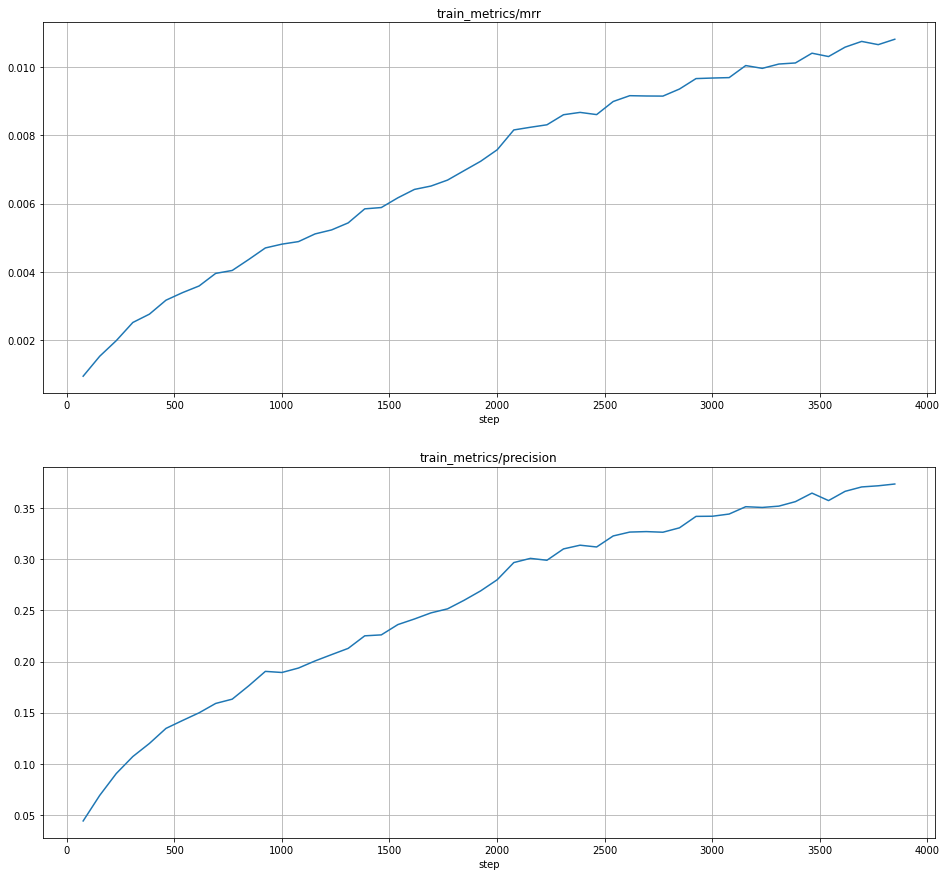

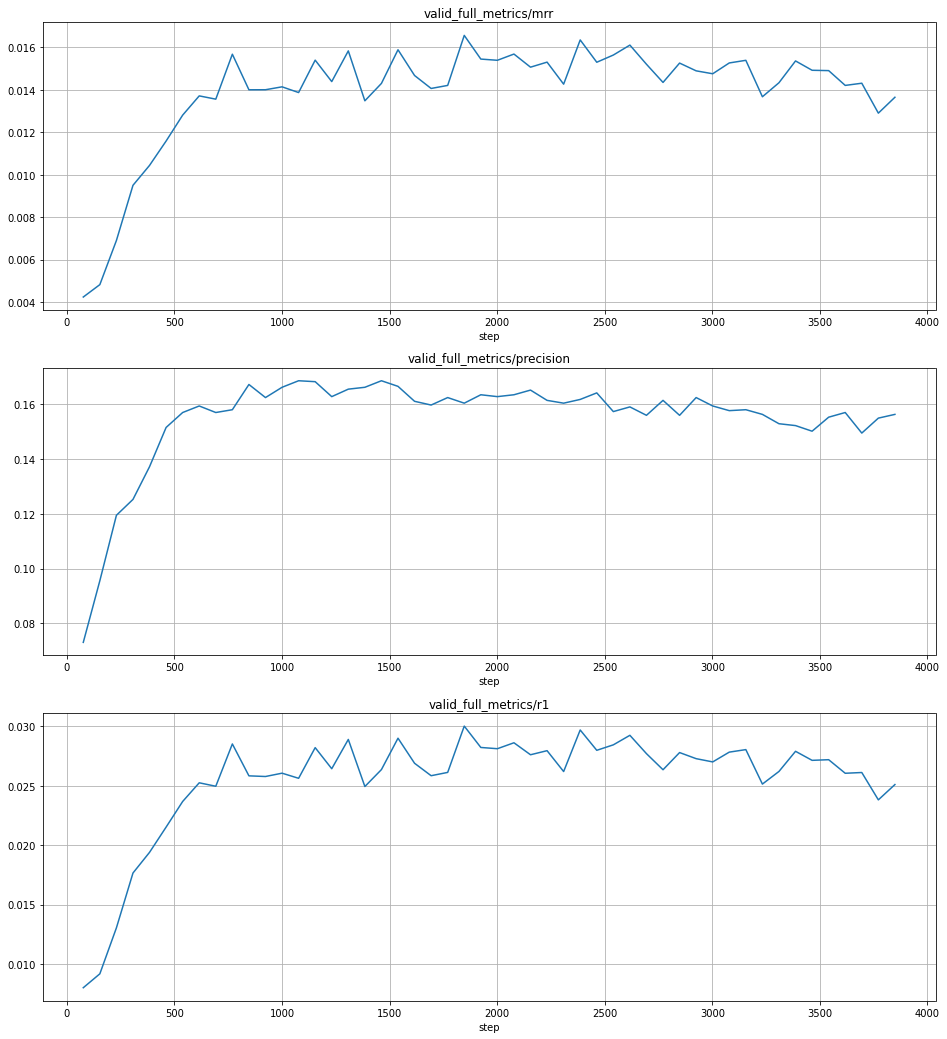

In [27]:
df_m = get_scalars('lightning_logs/').set_index('version').loc['version_69']

df = df_m[lambda x: x['tag'].str.startswith('train_metrics')] \
.pivot(index='step', columns='tag', values='value')
_, axs = plt.subplots(2, 1, figsize=(16, 15))
for col, ax in zip(df.columns, axs):
    df[col].plot(ax=ax, title=col, grid=True)
plt.show()

df = df_m[lambda x: x['tag'].str.startswith('valid_full_metrics')] \
.pivot(index='step', columns='tag', values='value')
_, axs = plt.subplots(3, 1, figsize=(16, 18))
for col, ax in zip(df.columns, axs):
    df[col].plot(ax=ax, title=col, grid=True)
plt.show()